In [18]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(1)

In [19]:
# Parameters
n_realizations = 2
n = 400 # number of observations, length of beta_star 
D = n 
p_star = 20 # number of non-zero predictors
sigma = 1 # noise parameter

<h1> Generating Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [20]:
def generate_data(dim, pstar, A, sigma, nrep):
  """
  Generate synthetic data.

  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real A: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  data = np.zeros((nrep, dim))       # Initialise
  data[:, :pstar] += A               # Add signal
  data += np.random.normal(0, sigma, size=(nrep, dim))  # Add noise
  return data

<h2> Defining the Model </h2>

$$\begin{align*} 
\gamma_i &= \sigma (z_\lambda / \lambda) \text{  for   } i = 1, ..., n \\
z_\lambda &= \frac{\lambda^2+\lambda+1}{\lambda+1} \log \frac{\alpha_i}{1-\alpha_i} + \log \frac{U_i}{1-U_i} \\
U_i &\sim \text{Uniform}(0, 1)
\end{align*}$$




In order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$. Some choices for $\alpha_i$ could be $\sigma(y)$, $\exp (y)$, etc.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [21]:
def model(alphas, lam):
    '''
    Defines the Concrete random variable distribution with REBAR adjustment

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
    '''
    D = alphas.shape
    U = numpyro.sample("U", dist.Uniform(0, 1).expand(D))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    T = numpyro.deterministic("T", jnp.log(alphas) - jnp.log(1-alphas))
    z_lam = numpyro.deterministic("z_lam", ((lam**2+lam+1)/(lam+1)) * T + L)

    gammas = numpyro.deterministic("gammas", sigmoid(z_lam/lam))
    kappas = numpyro.deterministic("kappas", 1-gammas)

In [22]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [23]:
def concrete(all_data, dim, pstar, lam):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11

    for A, y in all_data.items():
        
        beta_star = np.zeros(dim) 
        beta_star[:pstar] += A

        # print(np.exp(y).shape)
        # print(np.ones(shape=y).shape)

        alphas = sigmoid(y)
        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam)

        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        mean_gammas = mean_gammas.mean(axis=0) # mean across all repetitions

        estimated_betas = mean_gammas * beta_star
        beta_samples[A] = estimated_betas 

        mean_sq_errors[A] = jnp.mean((estimated_betas - beta_star)**2)
        
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, mean_gammas, beta_samples, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [24]:
all_mse_values = dict()
mean_mse_values = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []

all_data = {}
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smaller_A_values = [4, 6]
for A in A_values:
    all_data[A] = generate_data(dim=D, pstar=p_star, A=A, sigma=1, nrep=n_realizations) 

lams = [2, 1, 1/2, 1/100]

for lam in lams:
    mean_sq_errors, kappas, mean_gammas_lam, beta_samples, samples, mcmc = concrete(all_data, dim=D, pstar=p_star, lam=lam)

    all_mse_values[lam] = []
    all_mse_values[lam].append(mean_sq_errors)
    all_mse_values[lam] = np.array(all_mse_values[lam])
    mean_mse_values[lam] = np.mean(all_mse_values[lam], axis=0)

    all_kappas[lam] = []
    all_kappas[lam].extend(kappas)

    mean_gammas[lam] = mean_gammas_lam

    mean_betas[lam] = beta_samples

    all_mcmc_runs.append(mcmc)


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [25]:
for mcmc in all_mcmc_runs[::10]:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    U[0,0]      0.50      0.28      0.50      0.09      0.97   1979.15      1.00
    U[0,1]      0.50      0.28      0.50      0.02      0.89   1443.88      1.00
    U[0,2]      0.51      0.29      0.51      0.11      1.00   1191.92      1.00
    U[0,3]      0.51      0.28      0.52      0.09      0.96   1345.81      1.00
    U[0,4]      0.49      0.30      0.48      0.01      0.91   1824.91      1.00
    U[0,5]      0.49      0.29      0.49      0.10      0.99   1938.28      1.00
    U[0,6]      0.49      0.28      0.50      0.03      0.92   1778.45      1.00
    U[0,7]      0.50      0.29      0.50      0.06      0.95    905.19      1.00
    U[0,8]      0.50      0.29      0.50      0.03      0.92    681.56      1.00
    U[0,9]      0.49      0.28      0.48      0.05      0.93   2075.21      1.00
   U[0,10]      0.51      0.28      0.52      0.10      0.96   1606.22      1.00
   U[0,11]      0.49      0

<h1> Results </h1>

In [26]:
mean_gammas[2].shape

(400,)

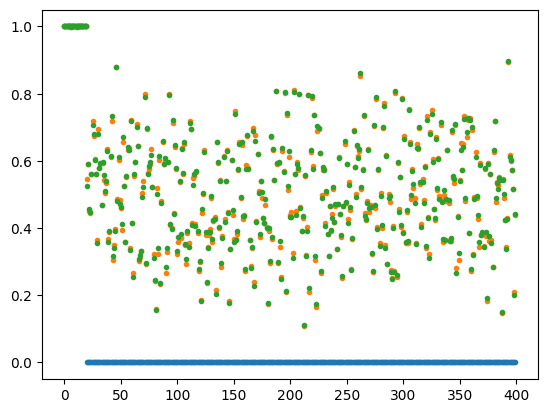

In [27]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="tight")

true_gamma = np.zeros(n)
true_gamma[:p_star] = 1

plt.plot(range(D), true_gamma, '.')
plt.plot(range(D), mean_gammas[2], '.')
plt.plot(range(D), mean_gammas[1/100], '.')


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_83300/2395349652.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


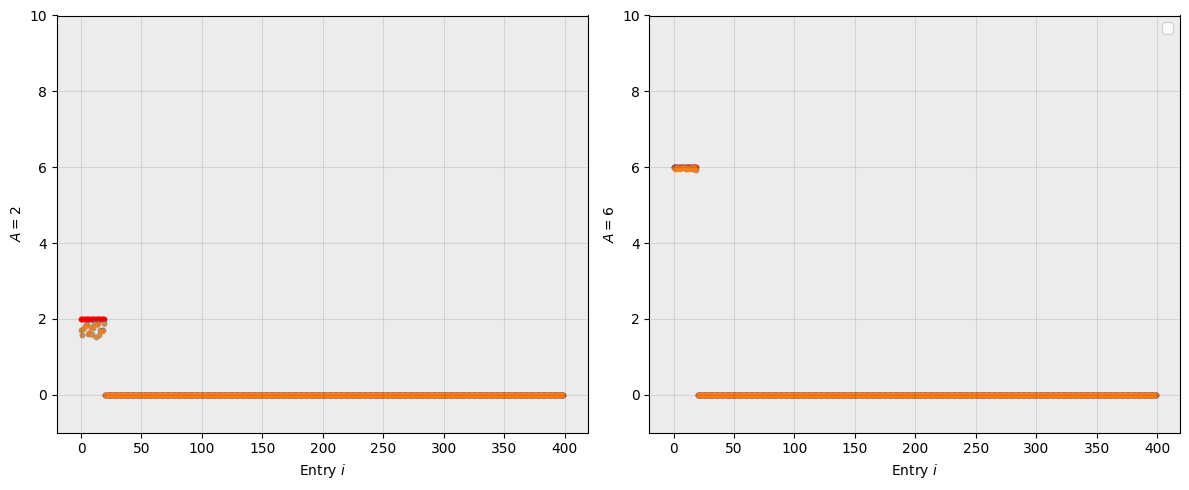

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="tight")
for ax in [ax1, ax2]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])

beta_star_6 = np.zeros(n)
beta_star_6[:p_star] = 6
beta_star_2 = np.zeros(n)
beta_star_2[:p_star] = 2

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax2.scatter(range(D), beta_star_6, color='red', s=10) 
for lam in [2, 1/100]:
    ax1.scatter(range(D), mean_betas[lam][2], s=10, alpha=0.5)
    ax2.scatter(range(D), mean_betas[lam][6], s=10, alpha=0.5)

# add labels to graph
ax1.set(ylabel=r'$A=2$', xlabel=r'Entry $i$')
ax2.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
plt.legend()


As $\lambda$ decreases, mean squared error decreases.

In [29]:
samples['T']

Array([[[ 1.0530712e+01,  1.1453738e+01,  9.5588083e+00, ...,
         -1.9535464e-01, -1.2848432e+00, -4.2790771e-03],
        [ 1.1453738e+01,  1.0938420e+01,  1.0530712e+01, ...,
          3.4475154e-01, -1.2608906e+00, -5.1483691e-01]],

       [[ 1.0530712e+01,  1.1453738e+01,  9.5588083e+00, ...,
         -1.9535464e-01, -1.2848432e+00, -4.2790771e-03],
        [ 1.1453738e+01,  1.0938420e+01,  1.0530712e+01, ...,
          3.4475154e-01, -1.2608906e+00, -5.1483691e-01]],

       [[ 1.0530712e+01,  1.1453738e+01,  9.5588083e+00, ...,
         -1.9535464e-01, -1.2848432e+00, -4.2790771e-03],
        [ 1.1453738e+01,  1.0938420e+01,  1.0530712e+01, ...,
          3.4475154e-01, -1.2608906e+00, -5.1483691e-01]],

       ...,

       [[ 1.0530712e+01,  1.1453738e+01,  9.5588083e+00, ...,
         -1.9535464e-01, -1.2848432e+00, -4.2790771e-03],
        [ 1.1453738e+01,  1.0938420e+01,  1.0530712e+01, ...,
          3.4475154e-01, -1.2608906e+00, -5.1483691e-01]],

       [[ 1.0530712

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

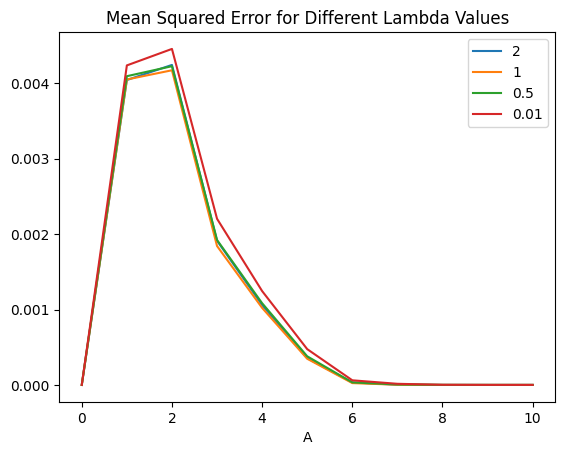

In [30]:
for lam in lams:
    plt.plot(range(len(mean_mse_values[lam])), mean_mse_values[lam], label=f'{lam}')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

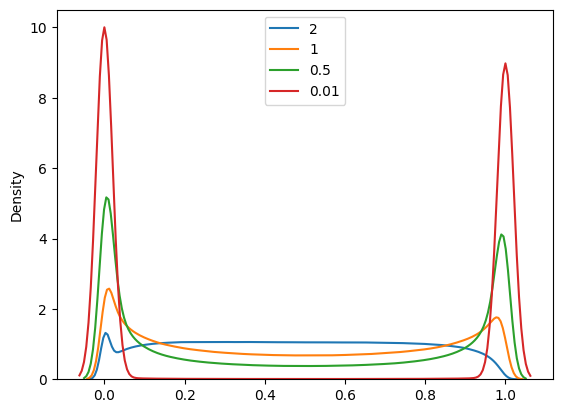

In [31]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()